In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

import plotly.express as px

# Обзор данных

In [2]:
data = pd.read_csv('movie_bd_v5.csv')  # Загружает датасет, с которым предстоит работать
data.sample(5)

,imdb_id,budget,revenue,original_title,cast,director,tagline,overview,runtime,genres,production_companies,release_date,vote_average,release_year
1569,tt0343818,120000000,347234916,"I, Robot",Will Smith|Bridget Moynahan|Alan Tudyk|James C...,Alex Proyas,Laws are made to be broken.,"In the year 2035, where robots are common and ...",115,Action|Science Fiction,Twentieth Century Fox Film Corporation|Laurenc...,7/15/2004,6.6,2004
907,tt0160184,55000000,6416302,D-Tox,Sylvester Stallone|Courtney B. Vance|Tom Beren...,Jim Gillespie,Survival is a Killer.,A disgraced FBI agent with a drinking problem ...,96,Action|Thriller,Universal Pictures,1/4/2002,5.8,2002
1403,tt0372532,15000000,47175038,The Wedding Date,Debra Messing|Dermot Mulroney|Amy Adams|Jack D...,Clare Kilner,Love doesn't come cheap.,With the wedding of her younger sister fast ap...,88,Comedy|Romance,Universal Pictures|26 Films,2/4/2005,6.2,2005
125,tt2084970,14000000,233555708,The Imitation Game,Benedict Cumberbatch|Keira Knightley|Matthew G...,Morten Tyldum,The true enigma was the man who cracked the code.,Based on the real life story of legendary cryp...,113,History|Drama|Thriller|War,Black Bear Pictures|Bristol Automotive,11/14/2014,8.0,2014
1851,tt0209958,33000000,104155843,The Cell,Jennifer Lopez|Vincent D'Onofrio|Vince Vaughn|...,Tarsem Singh,Enter The Mind Of A Killer,A psychotherapist journeys inside a comatose s...,107,Horror|Science Fiction|Thriller,New Line Cinema|Avery Pix|Radical Media|Katira...,8/17/2000,5.7,2000


In [3]:
data.info()  # Проверяем, есть ли пропуски в данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               1889 non-null   object 
 1   budget                1889 non-null   int64  
 2   revenue               1889 non-null   int64  
 3   original_title        1889 non-null   object 
 4   cast                  1889 non-null   object 
 5   director              1889 non-null   object 
 6   tagline               1889 non-null   object 
 7   overview              1889 non-null   object 
 8   runtime               1889 non-null   int64  
 9   genres                1889 non-null   object 
 10  production_companies  1889 non-null   object 
 11  release_date          1889 non-null   object 
 12  vote_average          1889 non-null   float64
 13  release_year          1889 non-null   int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 206.7+ KB


**Описания признаков:**
* imdb_id - идентификатор 
* budget - бюджет 
* revenue - сборы 
* original_title - оригинальное название
* cast - актёры
* director - режиссёр
* tagline - слоган 
* overview - описание 
* runtime - продолжительность
* genres - жанры
* production_companies - производственные компании
* release_date - дата релиза
* vote_average - средний рейтинг
* release_year - год производства

Пропусков нет. Данные представлены разных типов. С некоторыми признаками надо будет "поработать", чтобы вытащить необходимую информацию для ответа на вопросы (cast, genres, production_companies, release_date) сгруппировав по ним данные.

# Предобработка

In [4]:
def season(month):
    """Функция принимает название месяца и возвращает время года"""
    if month in ['June', 'July', 'August']:
        return "Summer"
    elif month in ['September', 'October', 'November']:
        return "Autumn"
    elif month in ['December', 'January', 'February']:
        return "Winter"
    else:
        return "Spring"


# Преобразуем строку с датой в формат datetime
data['release_date'] = pd.to_datetime(data.release_date)

# Добавление колонки с прибылью
data['profit'] = data['revenue'] - data['budget']
# Добавление колонки с длиной названия фильма
data['len_title'] = data['original_title'].apply(lambda x: len(x))
# Добавление колонки с количеством слов в описании
data['words_in_overview'] = data['overview'].apply(lambda x: len(x.split(' ')))
# Добавим колонку с названием месяца
data['month'] = data.release_date.dt.month_name()
# Добавим колонку с сезоном года
data['season'] = data.month.apply(season)

# Разделение данных в колонках с несколькими строковыми значениями для дальнейшей работы
data['genres'] = data['genres'].str.split('|')
data['cast'] = data['cast'].str.split('|')
data['director'] = data['director'].str.split('|')
data['production_companies'] = data['production_companies'].str.split('|')

answers = {}  # создадим словарь для ответов на вопросы

In [5]:
data.sample(3)  # Посмотрим на датасет после обработки

,imdb_id,budget,revenue,original_title,cast,director,tagline,overview,runtime,genres,production_companies,release_date,vote_average,release_year,profit,len_title,words_in_overview,month,season
1361,tt0374536,85000000,131426169,Bewitched,"[Nicole Kidman, Will Ferrell, Shirley MacLaine...",[Nora Ephron],Be warned. Be ready.,Thinking he can overshadow an unknown actress ...,102,"[Comedy, Fantasy, Romance]","[Columbia Pictures Corporation, Red Wagon Ente...",2005-06-21,4.9,2005,46426169,9,28,June,Summer
845,tt1462041,50000000,38502340,Dream House,"[Daniel Craig, Naomi Watts, Rachel Weisz, Mart...",[Jim Sheridan],"Once upon a time, there were two little girls ...","Publisher, Will Atenton quits a lucrative job ...",92,"[Drama, Thriller, Mystery]","[Cliffjack Motion Pictures, Morgan Creek Produ...",2011-09-30,5.9,2011,-11497660,11,73,September,Autumn
1027,tt1636826,12000000,100000000,Project X,"[Oliver Cooper, Jonathan Daniel Brown, Thomas ...",[Nima Nourizadeh],Witness it,Three high school seniors throw a party to mak...,88,"[Comedy, Crime]","[Silver Pictures, Green Hat Films]",2012-03-01,6.5,2012,88000000,9,28,March,Spring


# Вопросы и ответы на них

## 1. У какого фильма из списка самый большой бюджет?

Фильм, с самым большим бюджетом: Pirates of the Caribbean: On Stranger Tides / 380000000 $


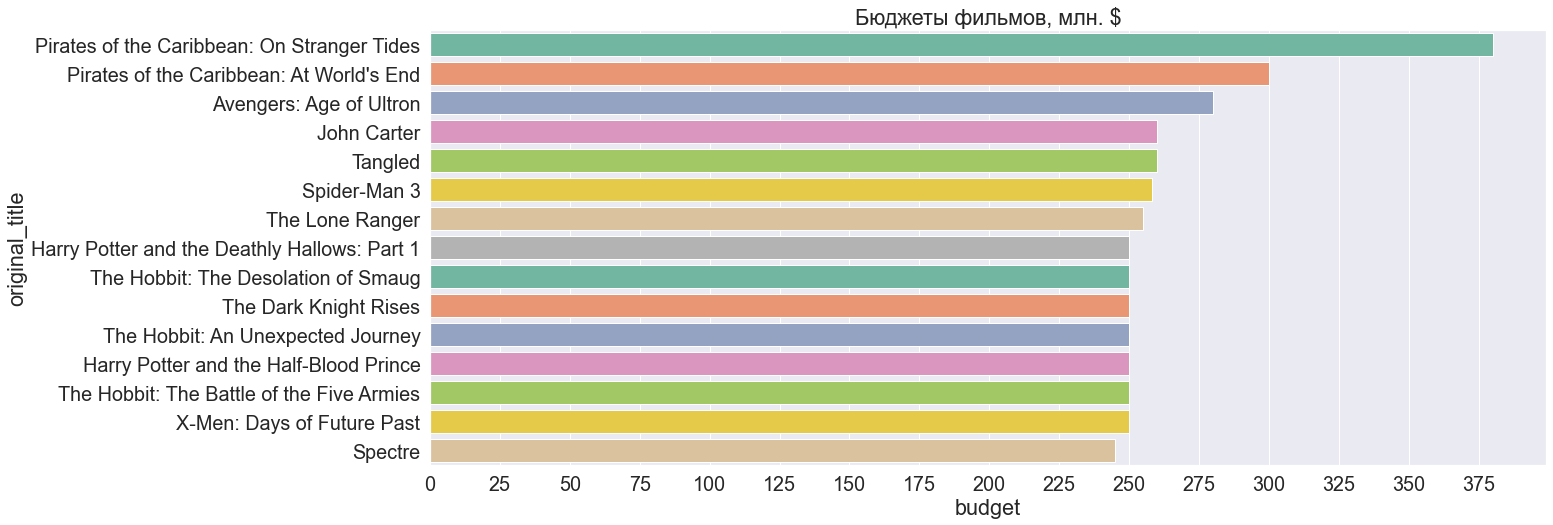

In [6]:
print('Фильм, с самым большим бюджетом: {} / {} $'.format(
    (data[data['budget'] == data['budget'].max()]['original_title'].iloc[0]),
    (data[data['budget'] == data['budget'].max()]['budget'].iloc[0])))

# Построим график для первых 15-ти фильмов по бюджету
sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 8))
plt.title('Бюджеты фильмов, млн. $')
plt.xticks(ticks=range(0, 400, 25))
sns.barplot(x=(data.sort_values(by='budget', ascending=False)[:15].budget)/1000000,
            y=data.sort_values(by='budget', ascending=False)[:15].original_title,
            palette='Set2',
            orient='h')

In [7]:
answers['1'] = data[data['budget'] == data['budget'].max()]['original_title'].iloc[0]  # Добавляем ответ в словарь

## 2. Какой из фильмов самый длительный (в минутах)?

Самый длительный фильм: Gods and Generals / 214 мин.


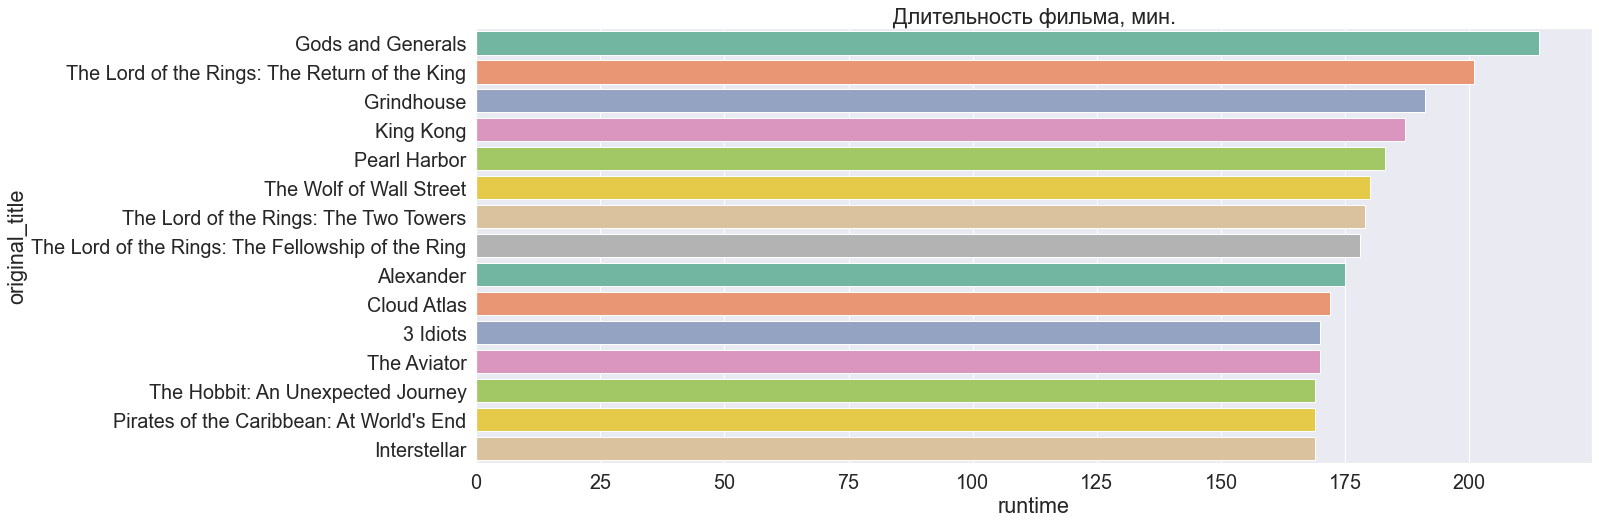

In [8]:
print('Самый длительный фильм: {} / {} мин.'.format(
    (data[data['runtime'] == data['runtime'].max()]['original_title'].iloc[0]),
    (data[data['runtime'] == data['runtime'].max()]['runtime'].iloc[0])))

# Построим график для первых 15-ти фильмов по длительности
sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 8))
plt.title('Длительность фильма, мин.')
sns.barplot(x=(data.sort_values(by='runtime', ascending=False)[:15].runtime),
            y=data.sort_values(by='runtime', ascending=False)[:15].original_title,
            palette='Set2',
            orient='h')

In [9]:
answers['2'] = data[data['runtime'] == data['runtime'].max()]['original_title'].iloc[0] 

## 3. Какой из фильмов самый короткий (в минутах)?

Самый короткий фильм: Winnie the Pooh / 63 мин.


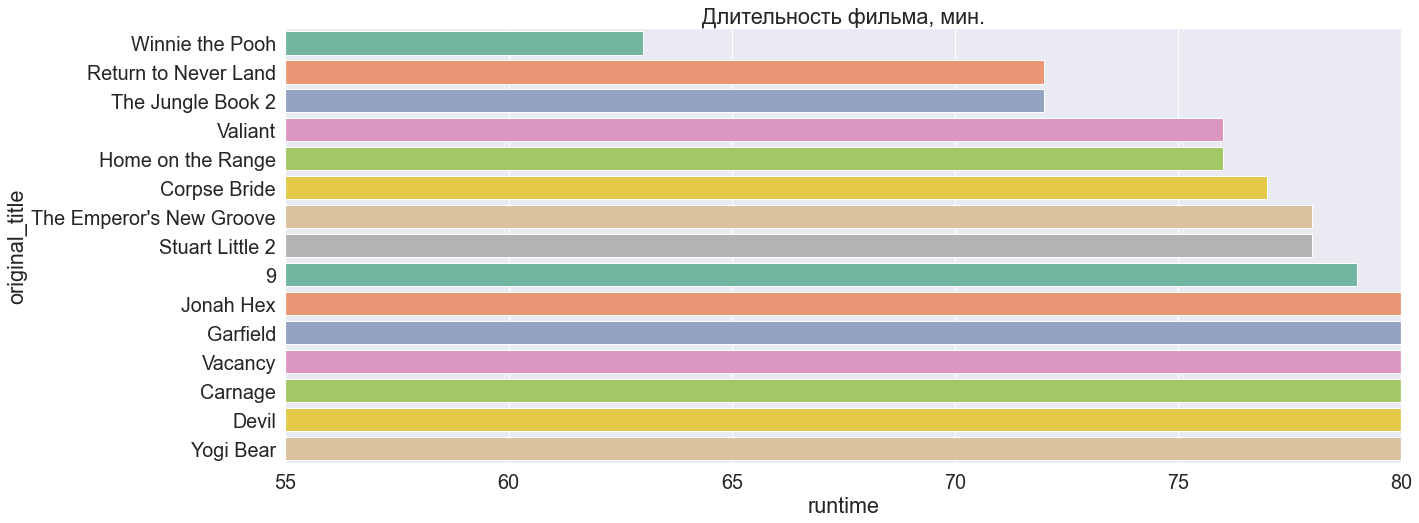

In [10]:
print('Самый короткий фильм: {} / {} мин.'.format(
    (data[data['runtime'] == data['runtime'].min()]['original_title'].iloc[0]),
    (data[data['runtime'] == data['runtime'].min()]['runtime'].iloc[0])))

sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 8))
plt.xlim(55, 80)
plt.title('Длительность фильма, мин.')
sns.barplot(x=(data.sort_values(by='runtime')[:15].runtime),
            y=data.sort_values(by='runtime')[:15].original_title,
            palette='Set2',
            orient='h')

In [11]:
answers['3'] = data[data['runtime'] == data['runtime'].min()]['original_title'].iloc[0]

## 4. Какова средняя длительность фильмов?

In [12]:
print('Средняя продолжительность фильмов : {:.2f} мин.'.format(data['runtime'].mean()))

Средняя продолжительность фильмов : 109.66 мин.


In [13]:
answers['4'] = data['runtime'].mean() 

## 5. Каково медианное значение длительности фильмов? 

Медианное значение длительности фильмов : 107.0 мин.


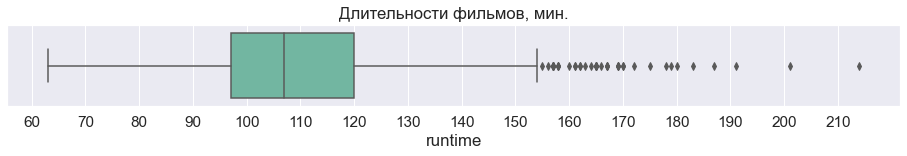

In [14]:
print('Медианное значение длительности фильмов : {} мин.'.format(data['runtime'].median()))

sns.set(font_scale=1.4)
plt.subplots(figsize=(16, 1.5))
plt.title('Длительности фильмов, мин.')
plt.xticks(ticks = range(60, 220, 10))
sns.boxplot(x=data.runtime, palette="Set2")

In [15]:
answers['5'] = data['runtime'].median() 

## 6. Какой самый прибыльный фильм?
#### Внимание! Здесь и далее под «прибылью» или «убытками» понимается разность между сборами и бюджетом фильма. (прибыль = сборы - бюджет) в нашем датасете это будет (profit = revenue - budget) 

Самый прибыльный фильм: Avatar / 2544505847 $


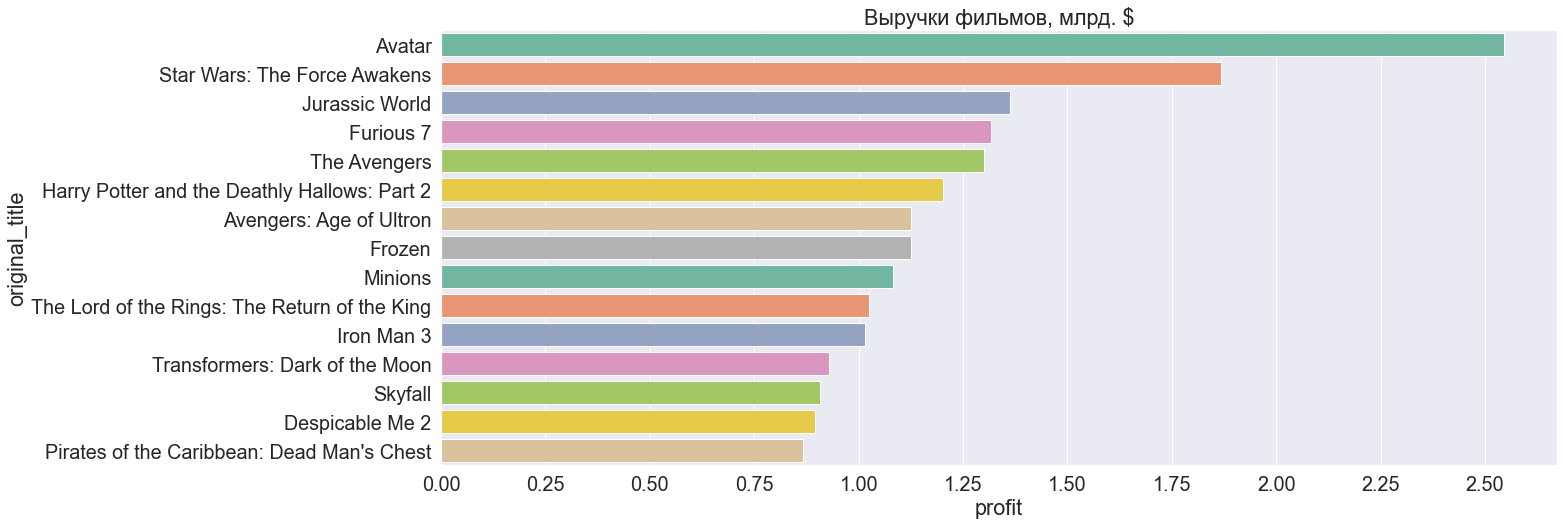

In [16]:
print('Самый прибыльный фильм: {} / {} $'.format(
    (data[data['profit'] == data['profit'].max()]['original_title'].iloc[0]),
    (data[data['profit'] == data['profit'].max()]['profit'].iloc[0])))

# Построим график самых прибыльных фильмов
sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 8))
plt.title('Выручки фильмов, млрд. $')
plt.xticks(ticks=np.arange(0, 3, 0.25))
sns.barplot(x=(data.sort_values(by='profit', ascending=False)[:15].profit)/1000000000,
            y=data.sort_values(by='profit', ascending=False)[:15].original_title,
            palette='Set2',
            orient='h')

In [17]:
answers['6'] = data[data['profit'] == data['profit'].max()]['original_title'].iloc[0]

## 7. Какой фильм самый убыточный? 

Самый убыточный фильм: The Lone Ranger / -165710090 $


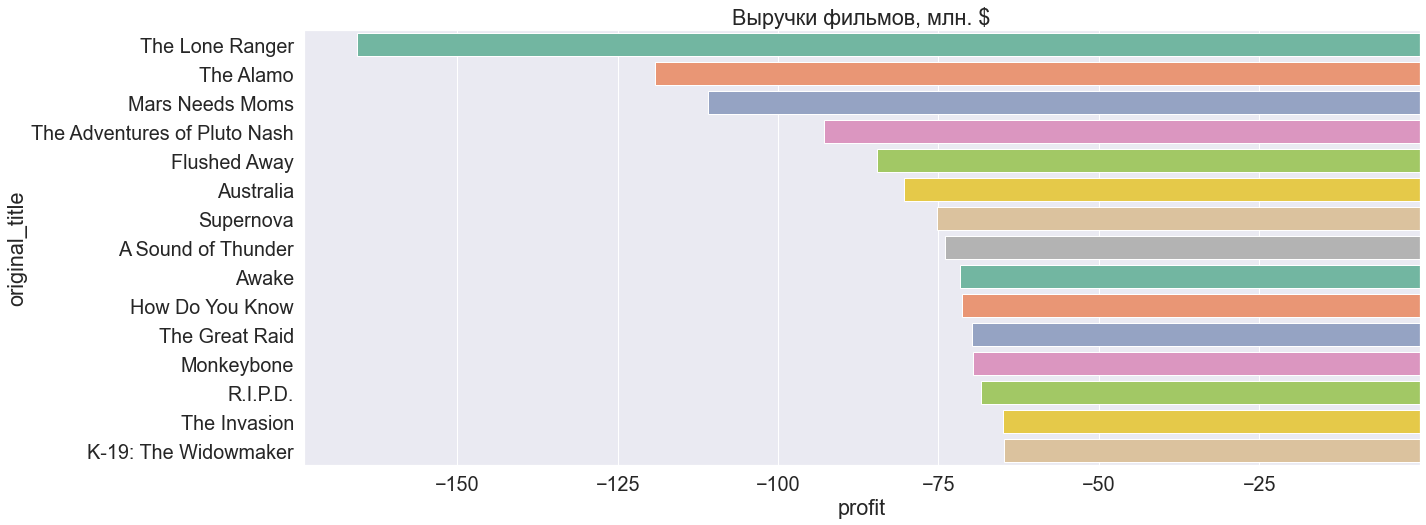

In [18]:
print('Самый убыточный фильм: {} / {} $'.format(
    (data[data['profit'] == data['profit'].min()]['original_title'].iloc[0]),
    (data[data['profit'] == data['profit'].min()]['profit'].iloc[0])))

# Построим график самых убыточных фильмов
sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 8))
plt.title('Выручки фильмов, млн. $')
plt.xticks(ticks=range(-300, 0, 25))
sns.barplot(x=(data.sort_values(by='profit')[:15].profit)/1000000,
            y=data.sort_values(by='profit')[:15].original_title,
            palette='Set2',
            orient='h')

In [19]:
answers['7'] = data[data['profit'] == data['profit'].min()]['original_title'].iloc[0]

## 8. У скольких фильмов из датасета объем сборов оказался выше бюджета?

In [20]:
print("Прибыльных фильмов: {} штук | {:.2%} от всех фильмов в датасете".format(
    len(data[data['profit'] > 0]), ((len(data[data['profit'] > 0]) / len(data)))))

Прибыльных фильмов: 1478 штук | 78.24% от всех фильмов в датасете


In [21]:
answers['8'] = len(data[data['profit'] > 0])  

## 9. Какой фильм оказался самым кассовым в 2008 году?

Самый прибыльный фильм в 2008 году: The Dark Knight / 816921825 $


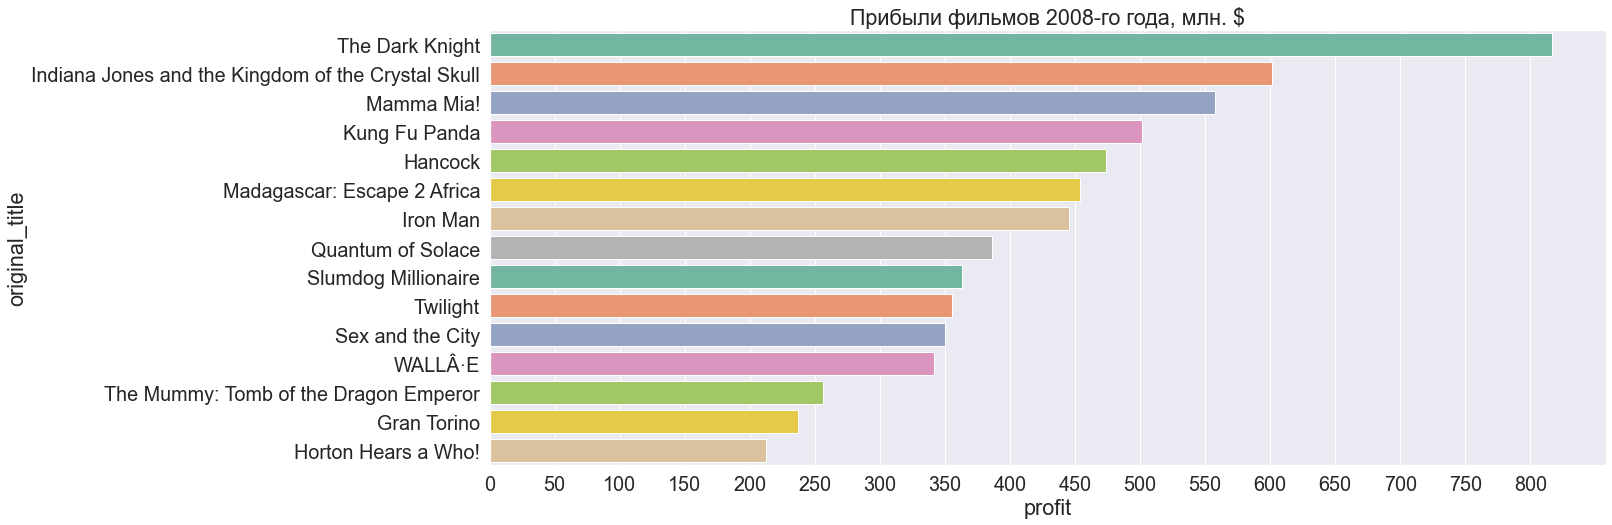

In [22]:
data_2008 = data[data['release_year'] == 2008]
print('Самый прибыльный фильм в 2008 году: {} / {} $'.format(
    (data_2008[data_2008['profit'] == data_2008['profit'].max()]['original_title'].iloc[0]),
    (data_2008[data_2008['profit'] == data_2008['profit'].max()]['profit'].iloc[0])))

# Посмотрим на самые прибыльные фильмы 2008-го года
sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 8))
plt.title('Прибыли фильмов 2008-го года, млн. $')
plt.xticks(ticks=range(0, 850, 50))
sns.barplot(x=(data_2008.sort_values(by='profit', ascending=False)[:15].profit)/1000000,
            y=data_2008.sort_values(by='profit', ascending=False)[:15].original_title,
            palette='Set2',
            orient='h')

In [23]:
answers['9'] = data_2008[data_2008['profit'] == data_2008['profit'].max()]['original_title'].iloc[0]

## 10. Самый убыточный фильм за период с 2012 по 2014 г. (включительно)?


Самый убыточный фильм в 2012-2014 году: The Lone Ranger / -165710090 $


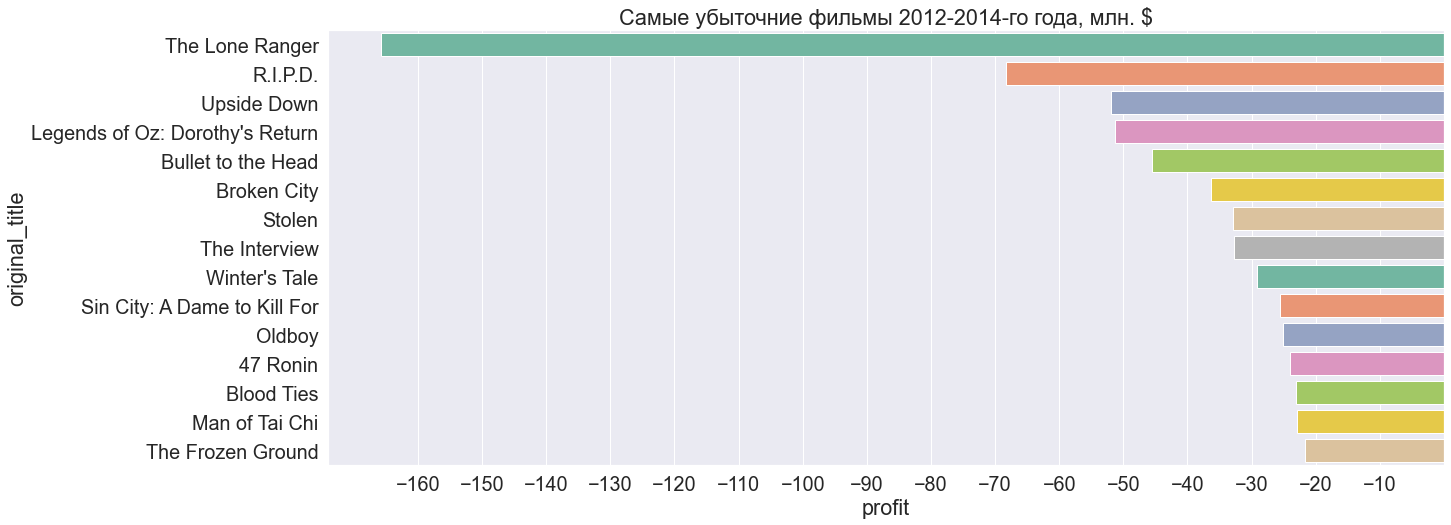

In [24]:
data_2012_2014 = data[((data['release_year'] >= 2012) &
                       (data['release_year'] <= 2014))]
print('Самый убыточный фильм в 2012-2014 году: {} / {} $'.format(
    (data_2012_2014[data_2012_2014['profit'] ==
                    data_2012_2014['profit'].min()]['original_title'].iloc[0]),
    (data_2012_2014[data_2012_2014['profit'] == data_2012_2014['profit'].min()]['profit'].iloc[0])))

# Посмотрим на самые убыточние фильмы 2012-2014-го года
sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 8))
plt.title('Самые убыточние фильмы 2012-2014-го года, млн. $')
plt.xticks(ticks=range(-160, 0, 10))
sns.barplot(x=(data_2012_2014.sort_values(by='profit')[:15].profit)/1000000,
            y=data_2012_2014.sort_values(by='profit',)[:15].original_title,
            palette='Set2',
            orient='h')

In [25]:
answers['10'] = data_2012_2014[data_2012_2014['profit'] ==
                               data_2012_2014['profit'].min()]['original_title'].iloc[0]

## 11. Какого жанра фильмов больше всего?

Размер нового датасета: (5107, 20)
Фильмов жанра 'Drama' больше всего: 782 


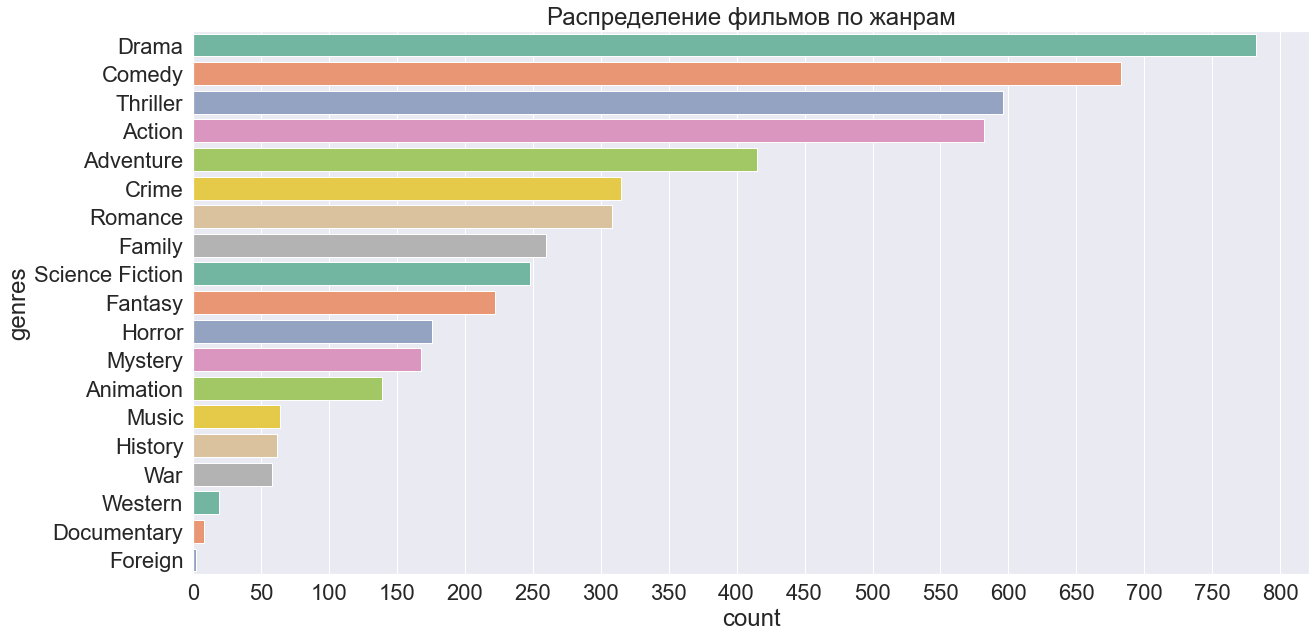

In [119]:
# Новый датасет, где в каждой строке в колонке genres только один жанр
data_genres = data.explode('genres')
print("Размер нового датасета: {}".format(data_genres.shape))
print("Фильмов жанра '{}' больше всего: {} ".format(
    (data_genres.genres.value_counts().idxmax()), data_genres.genres.value_counts().max()))

# Количество фильмов каждого жанра
sns.set(font_scale=2)
plt.subplots(figsize=(20, 10))
plt.xticks(ticks=range(0, 801, 50))
plt.title('Распределение фильмов по жанрам')
sns.countplot(y="genres",
              data=data_genres,
              order=data_genres.genres.value_counts().index,
              palette='Set2')

In [118]:
answers['11'] = data_genres['genres'].value_counts().idxmax()

## 12. Фильмы какого жанра чаще всего становятся прибыльными? 

Прибыльных фильмов жанра 'Drama' больше всего: 560 


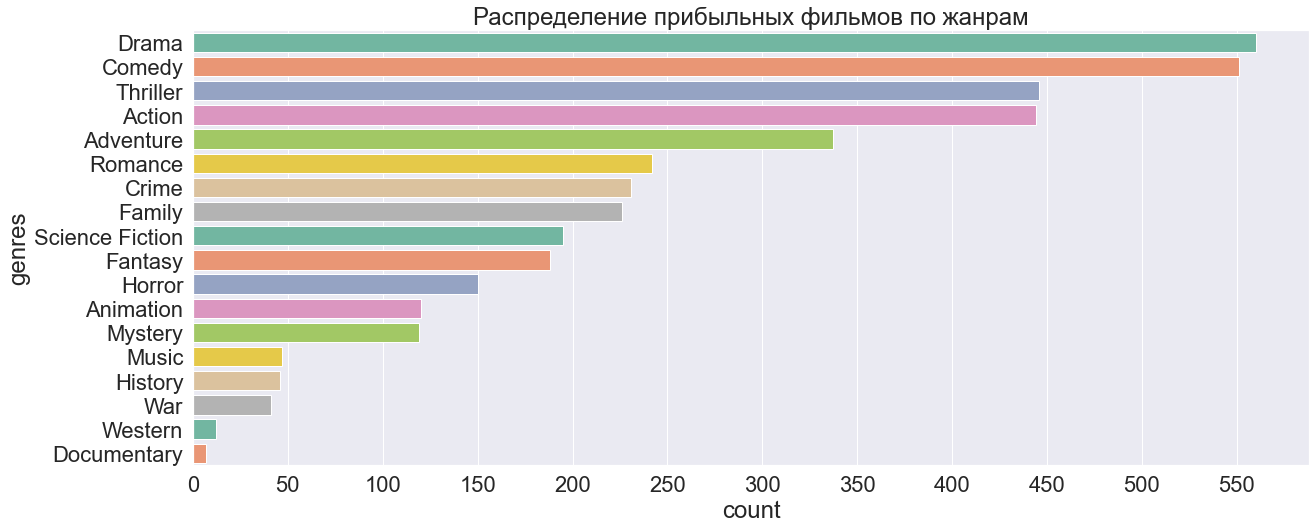

In [116]:
print("Прибыльных фильмов жанра '{}' больше всего: {} ".format(
    (data_genres[data_genres['profit'] > 0].genres.value_counts().idxmax()),
    data_genres[data_genres['profit'] > 0].genres.value_counts().max()))

# Количество прибыльных фильмов каждого жанра
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks=range(0, 601, 50))
plt.title('Распределение прибыльных фильмов по жанрам')
sns.countplot(y="genres",  
              data=data_genres[data_genres['profit'] > 0],
              order=data_genres[data_genres['profit'] > 0].genres.value_counts().index, 
              palette='Set2')

In [114]:
answers['12'] = data_genres[data_genres['profit'] > 0]['genres'].value_counts().idxmax()

## 13. У какого режиссера самые большие суммарные кассовые сборы?

Самые большие кассовые сборы (6490593685 $) у Peter Jackson


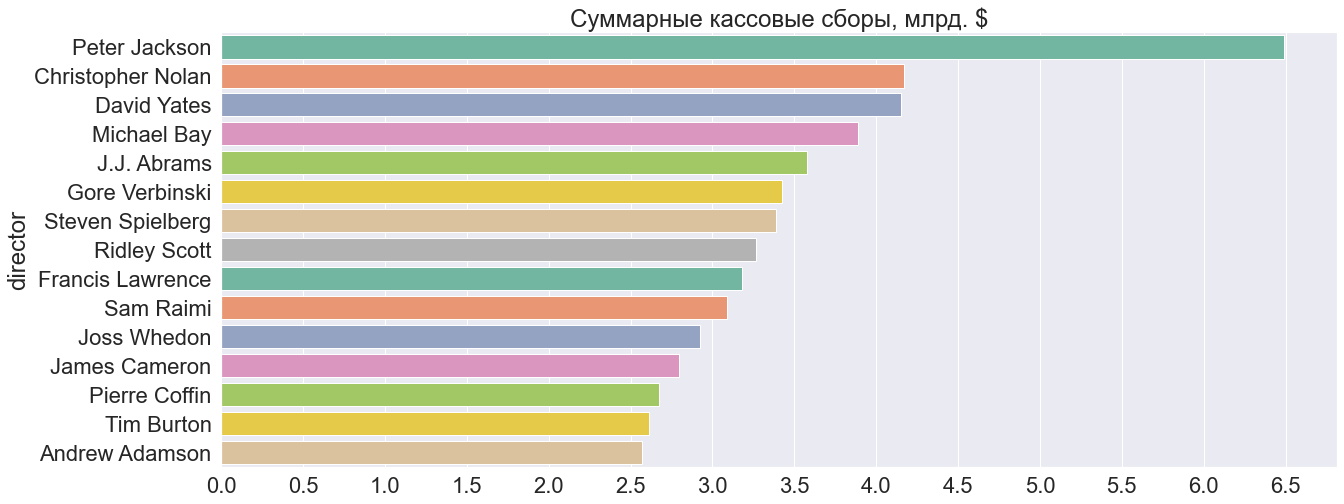

In [113]:
# Новый датасет, где в каждой строке в колонке director только один режиссер
data_director = data.explode('director') 
print("Самые большие кассовые сборы ({} $) у {}".format(
    (data_director.groupby(['director']).revenue.sum().sort_values(ascending=False).values[0]),
    (data_director.groupby(['director']).revenue.sum().sort_values(ascending=False).index[0])))

# Построим график для первых 15-ти режиссеров по кассовым сборам
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks=np.arange(0, 7, 0.5))
plt.title('Суммарные кассовые сборы, млрд. $')
sns.barplot(x=(data_director.groupby(['director']).revenue.sum().sort_values(ascending=False)[:15].values)/1000000000,
            y=data_director.groupby(['director']).revenue.sum().sort_values(ascending=False)[:15].index,
            palette='Set2', 
            orient='h')

In [31]:
answers['13'] = data_director.groupby(['director']).revenue.sum().idxmax() 

## 14. Какой режисер снял больше всего фильмов в стиле Action?

 Robert Rodriguez снял больше всего фильмов в стиле Action (9 штук)


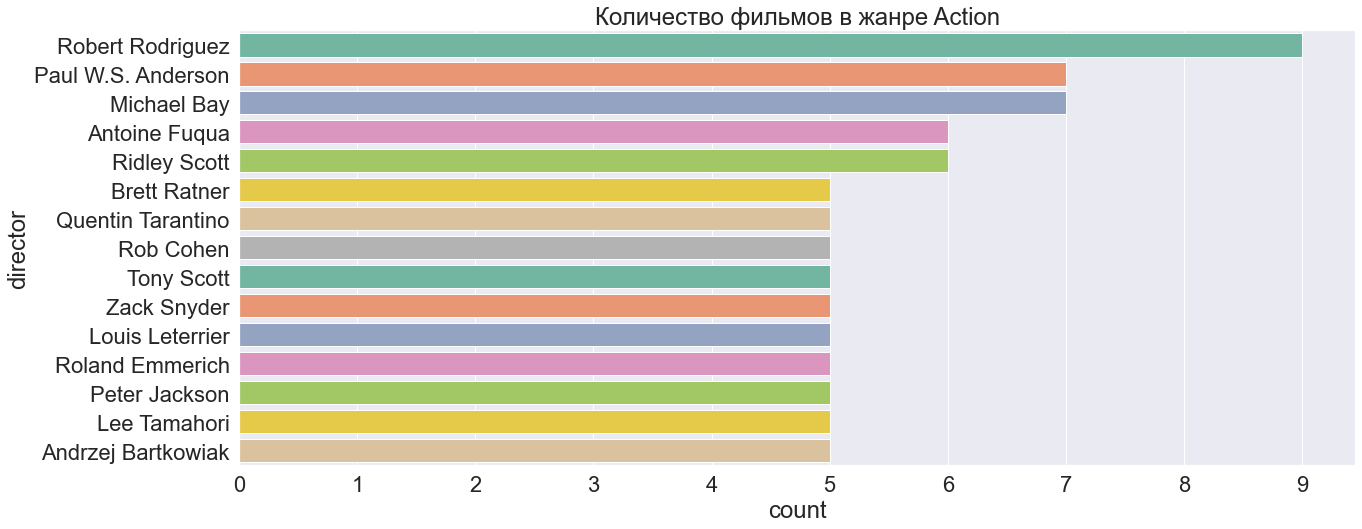

In [112]:
data_action = data_genres[data_genres['genres'] == 'Action']
data_act_dir = data_action.explode('director')  # Новый датасет по фильмам Action, где разбиты "режиссеры"

print(" {} снял больше всего фильмов в стиле Action ({} штук)".format(
    data_act_dir['director'].value_counts().idxmax(), 
    data_act_dir['director'].value_counts().max()))

# Построим график для первых 15-ти режиссеров по количеству
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks=range(0, 10, 1))
plt.title('Количество фильмов в жанре Action')
sns.countplot(y="director", 
              data=data_act_dir,
              order=data_act_dir.director.value_counts()[:15].index,
              palette='Set2')

In [109]:
answers['14'] = data_act_dir['director'].value_counts().idxmax()

## 15. Фильмы с каким актером принесли самые высокие кассовые сборы в 2012 году? 

Фильмы с участием Chris Hemsworth принесли самые высокие кассовые сборы в 2012 (2027450773 $)


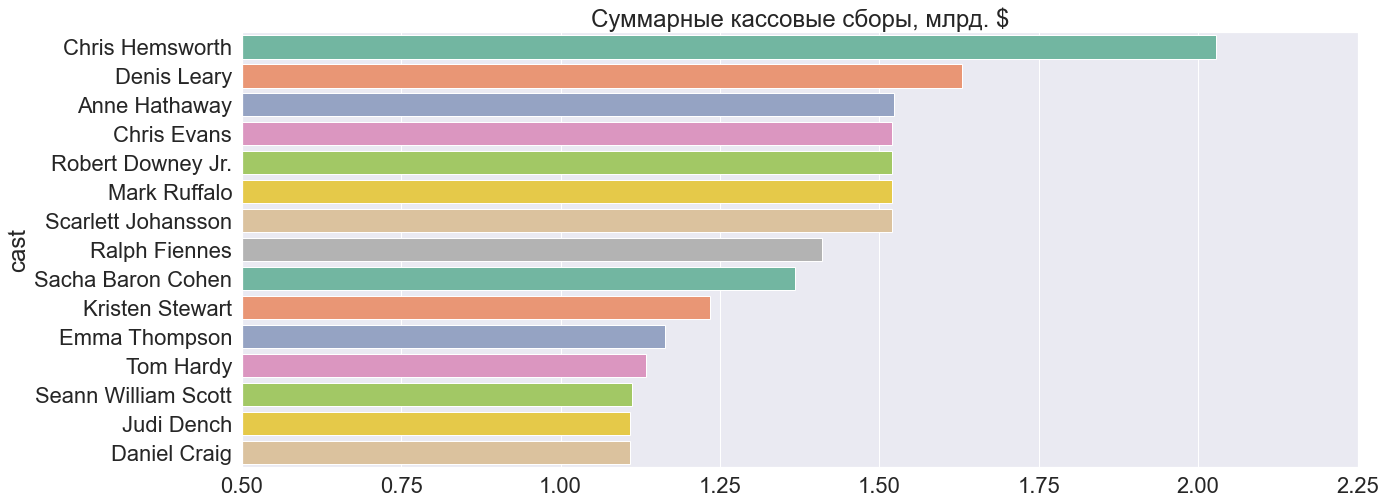

In [108]:
data_2012 = data[data.release_year == 2012].copy()
data_cast2012 = data_2012.explode('cast')

print("Фильмы с участием {} принесли самые высокие кассовые сборы в 2012 ({} $)".format(
    data_cast2012.groupby(['cast']).revenue.sum().idxmax(), 
    data_cast2012.groupby(['cast']).revenue.sum().max()))

# Построим график для первых 15-ти актёров по кассовым сборам за 2012 год
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.title('Суммарные кассовые сборы, млрд. $')
plt.xticks(ticks=np.arange(0.5, 2.3, 0.25))
plt.xlim(0.5, 2.25)
sns.barplot(x=data_cast2012.groupby(['cast']).revenue.sum().sort_values(ascending=False)[:15].values/1000000000,
            y=data_cast2012.groupby(['cast']).revenue.sum().sort_values(ascending=False)[:15].index,
            palette='Set2', 
            orient='h')

In [35]:
answers['15'] = data_cast2012.groupby(['cast']).revenue.sum().idxmax()

## 16. Какой актер снялся в большем количестве высокобюджетных фильмов?

Matt Damon cнялся в большем количестве высокобюджетных фильмов (18 штук)


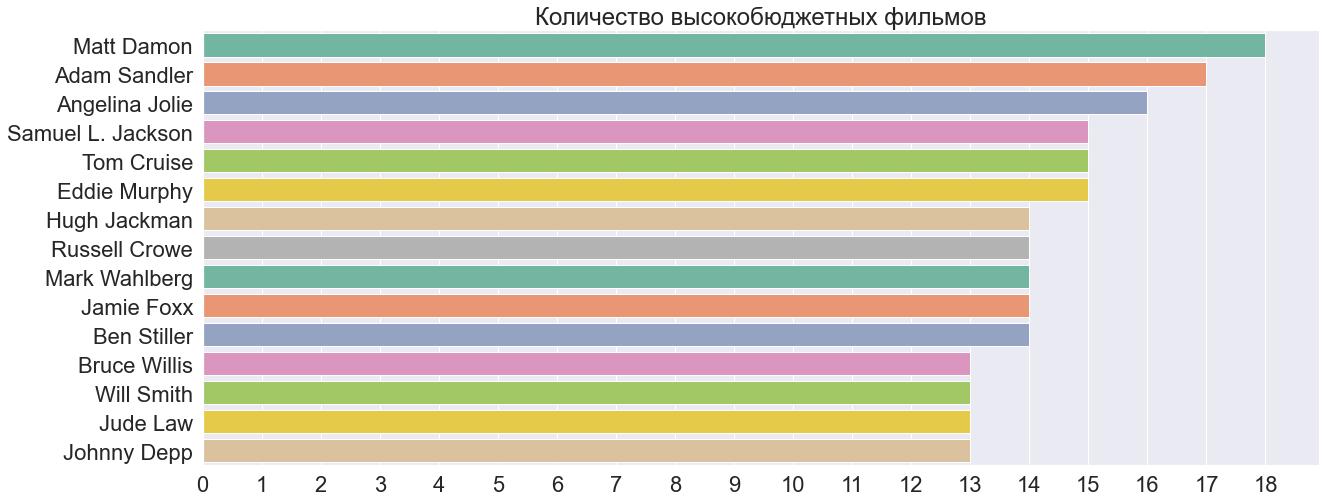

In [106]:
data_mome = data[data['budget'] > data['budget'].mean()]  # высокобюджетные - у которых бюджет выше среднего
data_cast_mome = data_mome.explode('cast')
data_cast_mome['cast'].value_counts()
print("{} cнялся в большем количестве высокобюджетных фильмов ({} штук)".format(
    data_cast_mome['cast'].value_counts().idxmax(), 
    data_cast_mome['cast'].value_counts().max()))

# Построим график для первых 15-ти актёров по cъемках в высокобюджетных фильмах
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks=range(0, 20))
plt.title('Количество высокобюджетных фильмов')
sns.color_palette("Set2")
sns.barplot(x=data_cast_mome['cast'].value_counts()[:15].values,
            y=data_cast_mome['cast'].value_counts()[:15].index,
            palette='Set2',
            orient='h')

In [104]:
answers['16'] = data_cast_mome['cast'].value_counts().idxmax()

## 17. В фильмах какого жанра больше всего снимался Nicolas Cage? 

Фильмов с Николасом Кейджем жанра Action больше всего (17 штук)


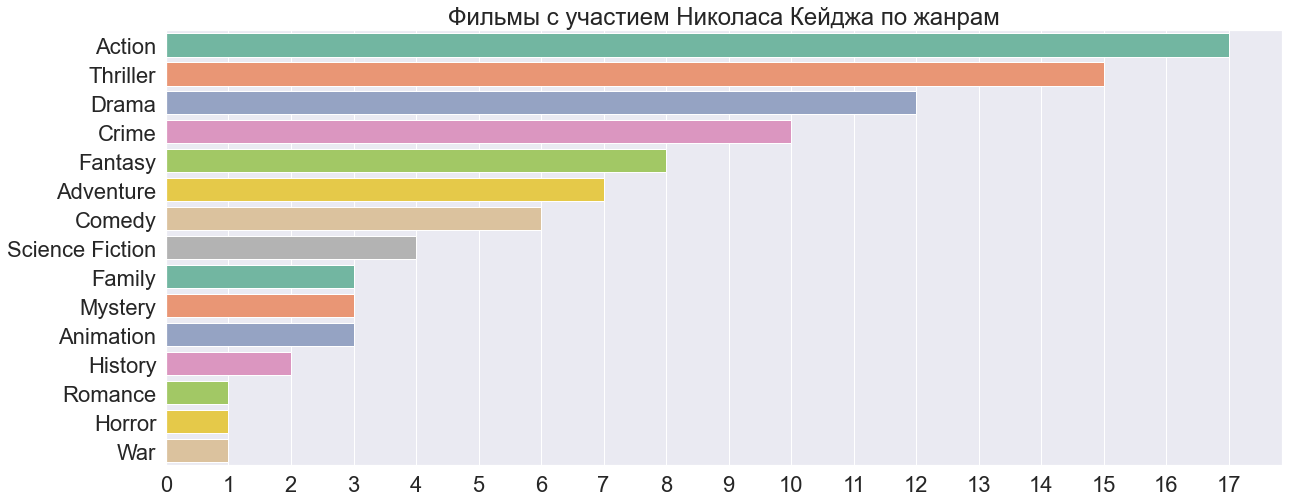

In [101]:
data_cast = data.explode('cast')
data_Cage = data_cast[data_cast['cast'] == 'Nicolas Cage']
data_genres_Cage = data_Cage.explode('genres')

print("Фильмов с Николасом Кейджем жанра {} больше всего ({} штук)".format(
    data_genres_Cage['genres'].value_counts().idxmax(), 
    data_genres_Cage['genres'].value_counts().max()))

# Количество фильмов каждого жанра с Николасом Кейджем
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks=range(0, 20, 1))
plt.title('Фильмы с участием Николаса Кейджа по жанрам')
sns.color_palette("Set2")
sns.barplot(x=data_genres_Cage['genres'].value_counts().values,
            y=data_genres_Cage['genres'].value_counts().index,
            palette='Set2', 
            orient='h')

In [97]:
answers['17'] = data_genres_Cage['genres'].value_counts().idxmax()

## 18. Самый убыточный фильм от Paramount Pictures

Самый убыточный фильм от Paramount Pictures: K-19: The Widowmaker (-64831034 $)


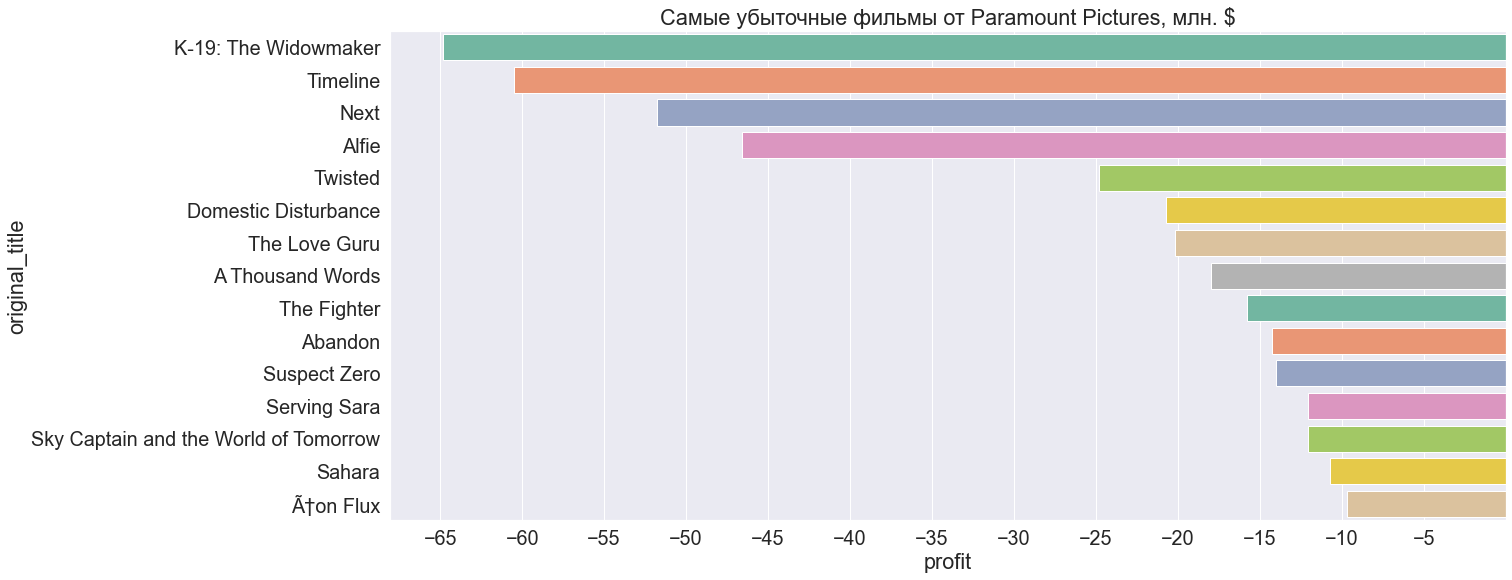

In [92]:
data_companies = data.explode('production_companies')
data_Paramount = data_companies[data_companies['production_companies'] == 'Paramount Pictures']

print("Самый убыточный фильм от Paramount Pictures: {} ({} $)".format(
    data_Paramount[['original_title', 'profit']].sort_values(['profit'])['original_title'].iloc[0]  , 
    data_Paramount[['original_title', 'profit']].sort_values(['profit'])['profit'].iloc[0]))

# Построим график 15-ти самых убыточных фильмов от Paramount Pictures
sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 9))
plt.xticks(ticks=range(-70, 0, 5))
plt.title('Самые убыточные фильмы от Paramount Pictures, млн. $')
sns.color_palette("Set2")
sns.barplot(x=(data_Paramount[['original_title', 'profit']].sort_values(['profit'])[:15]['profit'])/1000000,
            y=data_Paramount[['original_title', 'profit']].sort_values(['profit'])[:15]['original_title'],
            palette='Set2', 
            orient='h')

In [41]:
answers['18'] = data_Paramount[['original_title', 'profit']].sort_values(['profit'])['original_title'].iloc[0]  

## 19. Какой год стал самым успешным по суммарным кассовым сборам?

Самый успешный год по суммарным кассовым сборам: 2015 (25449202382 $)


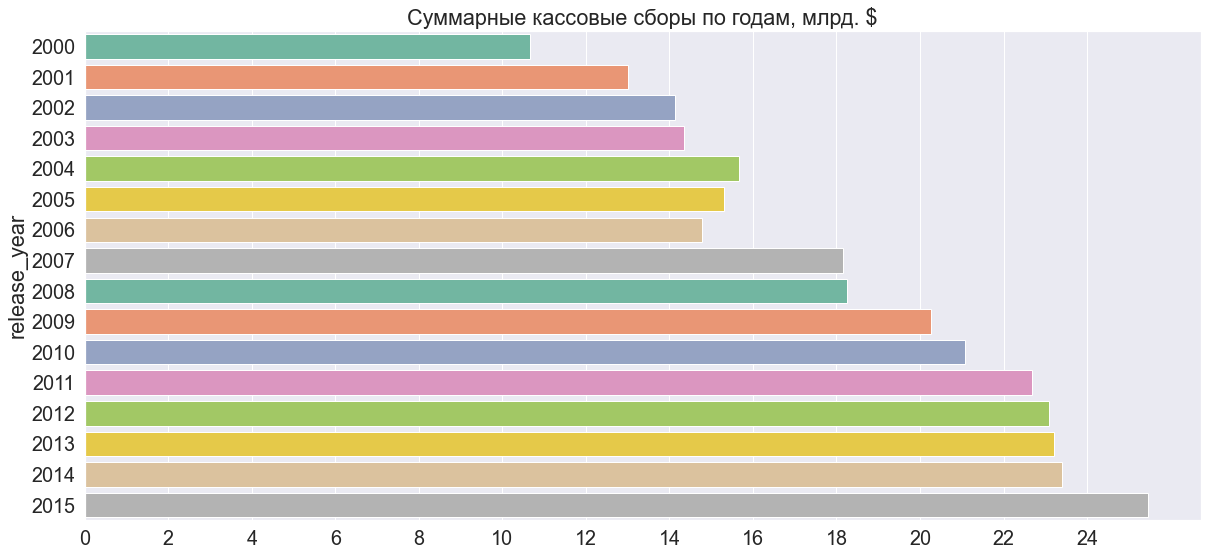

In [81]:
print("Самый успешный год по суммарным кассовым сборам: {} ({} $)".format(
    data.groupby('release_year')['revenue'].sum().index[-1], 
    data.groupby('release_year')['revenue'].sum().values[-1]))

sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 9))
plt.xticks(ticks=range(0, 25, 2))
plt.title('Суммарные кассовые сборы по годам, млрд. $')
sns.color_palette("Set2")
sns.barplot(x=data.groupby('release_year')['revenue'].sum().sort_values().values/1000000000,
            y=data.groupby('release_year')['revenue'].sum().sort_values().index,
            palette='Set2', 
            orient='h')

In [43]:
answers['19'] = data.groupby('release_year')['revenue'].sum().idxmax()  

## 20. Какой самый прибыльный год для студии Warner Bros?

Самый прибыльный год Warner Bros: 2014 (2292949646 $)


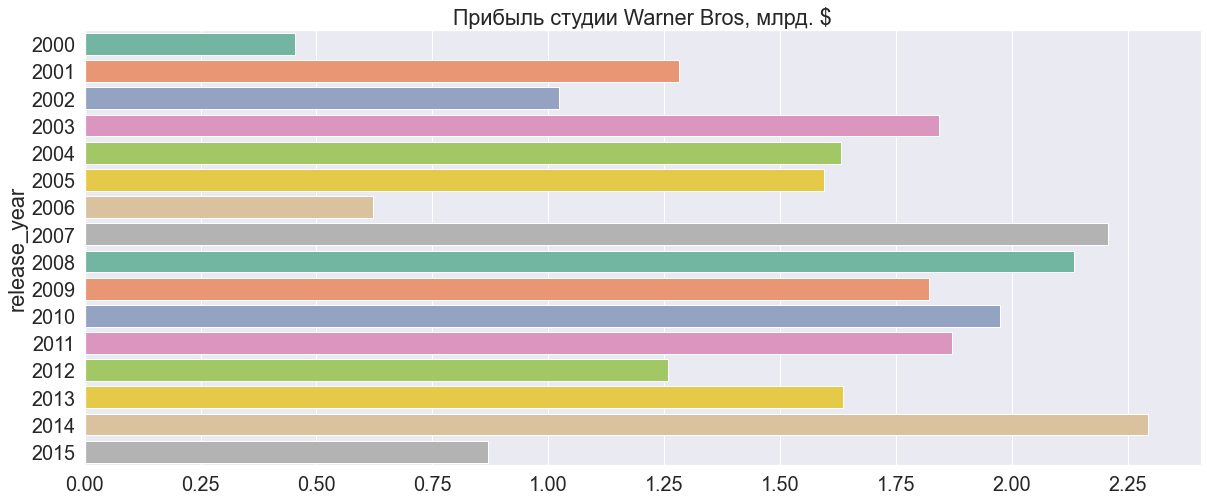

In [44]:
data_Warner = data_companies[data_companies['production_companies'].str.contains("Warner")]
data_Warner_profit = data_Warner.groupby(
    'release_year')['profit'].sum().sort_values(ascending=False).sort_index()

print("Самый прибыльный год Warner Bros: {} ({} $)".format(
    data_Warner_profit.idxmax(), data_Warner_profit.max()))

sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks=np.arange(0, 2.5, 0.25))
plt.title('Прибыль студии Warner Bros по годам, млрд. $')
sns.color_palette("Set2")
sns.barplot(x=data_Warner_profit.values/1000000000,
            y=data_Warner_profit.index,
            palette='Set2',
            orient='h')

In [45]:
answers['20'] = data_Warner.groupby('release_year')['profit'].sum().idxmax()

## 21. В каком месяце за все годы суммарно вышло больше всего фильмов?

Больше всего фильмов суммарно за все годы вышло в September (227 штук)


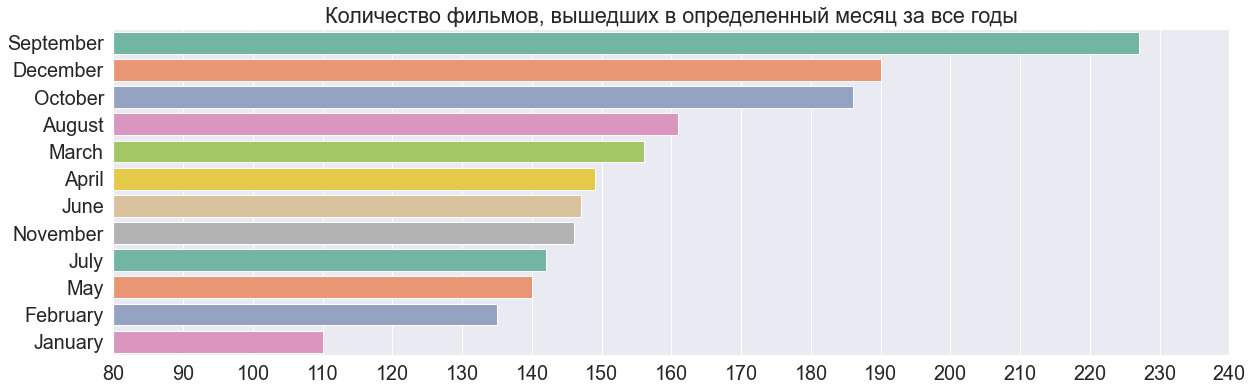

In [46]:
print("Больше всего фильмов суммарно за все годы вышло в {} ({} штук)".format(
    data['month'].value_counts().idxmax(),
    data['month'].value_counts().max()))

sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 6))
plt.title('Количество фильмов, вышедших в определенный месяц за все годы')
plt.xticks(ticks=range(0, 250, 10))
plt.xlim(80)
sns.barplot(x=data['month'].value_counts().sort_values(ascending=False).values,
            y=data['month'].value_counts().sort_values(ascending=False).index,
            palette='Set2',
            orient='h')

In [47]:
answers['21'] = data['month'].value_counts().idxmax()

## 22. Сколько суммарно вышло фильмов летом? (за июнь, июль, август)

Фильмов, вышедших летом: 450


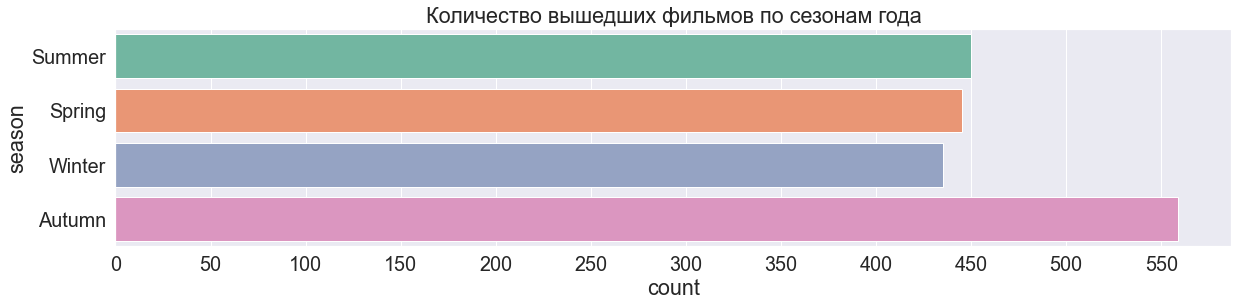

In [48]:
print('Фильмов, вышедших летом: {}'.format(len(data[data.season == 'Summer'])))

sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 4))
plt.title('Количество вышедших фильмов по сезонам года')
plt.xticks(ticks=range(0, 600, 50))
sns.countplot(y="season",  
              data=data, 
              palette='Set2')

In [49]:
answers['22'] = len(data[data.season == 'Summer'])

## 23. Для какого режиссера зима – самое продуктивное время года? 

Больше всего фильмов зимой выпустил Peter Jackson (7 штук)


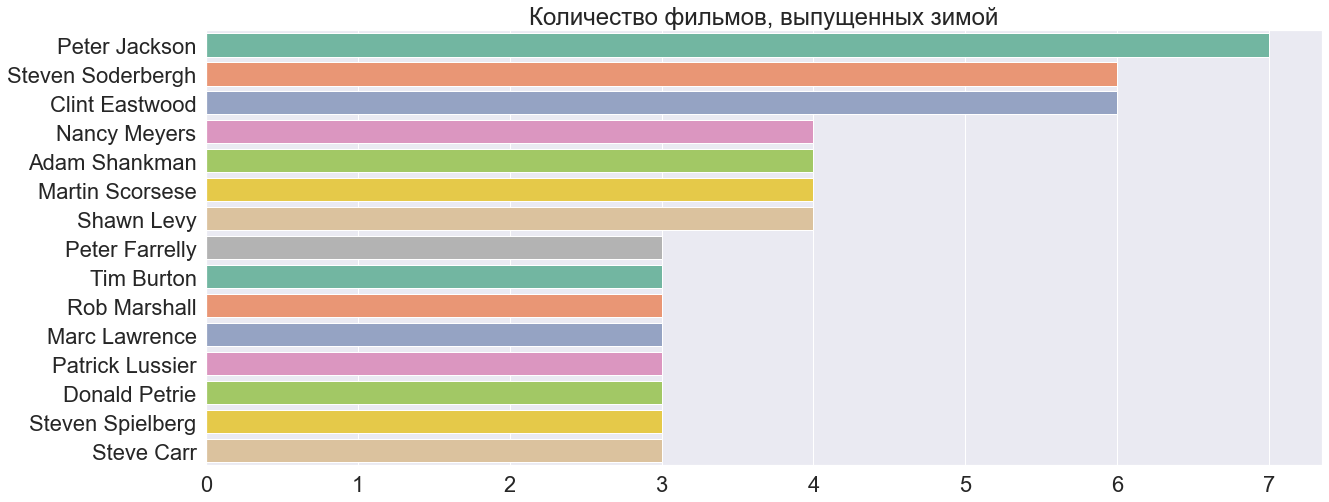

In [50]:
print("Больше всего фильмов зимой выпустил {} ({} штук)".format(
    data_director[data_director.season == 'Winter']['director'].value_counts().idxmax(),
    data_director[data_director.season == 'Winter']['director'].value_counts().max()))

sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.title('Количество фильмов, выпущенных зимой')
sns.color_palette("Set2")
sns.barplot(x=data_director[data_director.season == 'Winter']['director'].value_counts()[:15].values,
            y=data_director[data_director.season == 'Winter']['director'].value_counts()[:15].index,
            palette='Set2', 
            orient='h')

In [51]:
answers['23'] = data_director[data_director.season == 'Winter']['director'].value_counts().idxmax()

## 24. Какая студия дает самые длинные названия своим фильмам по количеству символов?

В среднее самые длинные названия фильмов у студии Four By Two Productions (83.0 символов)


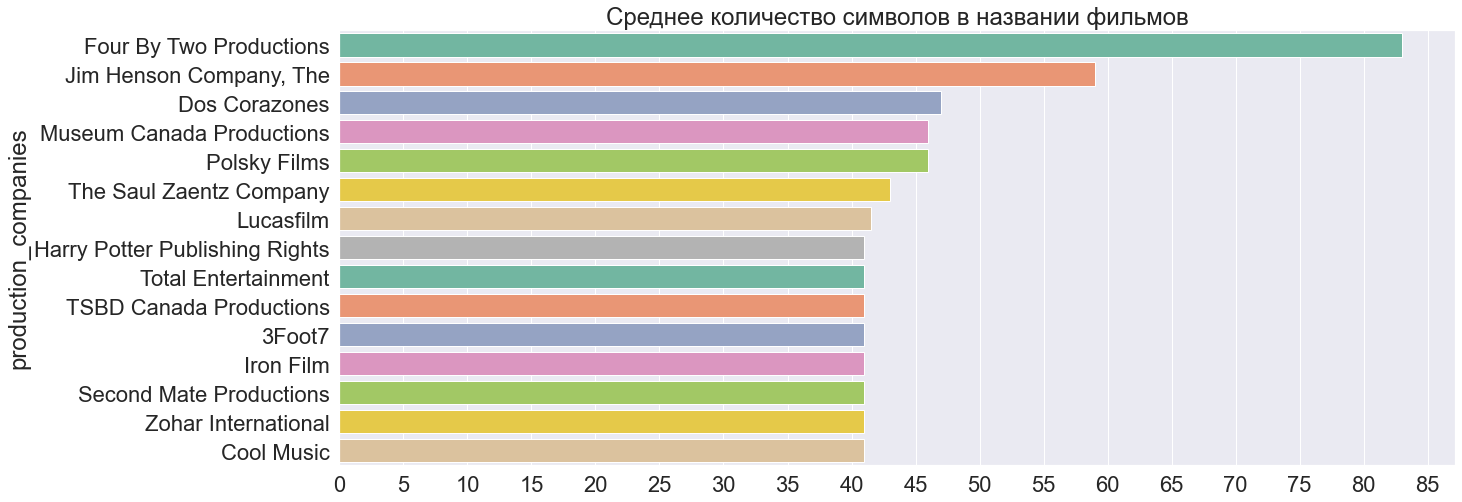

In [52]:
print("В среднее самые длинные названия фильмов у студии {} ({} символов)".format(
    data_companies.groupby(['production_companies'])['len_title'].mean().idxmax(),
    data_companies.groupby(['production_companies'])['len_title'].mean().max()))

sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.title('Среднее количество символов в названии фильмов')
plt.xticks(ticks=range(0, 90, 5))
sns.barplot(x=data_companies.groupby(['production_companies'])['len_title'].mean().sort_values(ascending=False)[:15].values,
            y=data_companies.groupby(['production_companies'])['len_title'].mean().sort_values(ascending=False)[:15].index,
            palette='Set2', 
            orient='h')

In [53]:
answers['24'] = data_companies.groupby(['production_companies'])['len_title'].mean().idxmax()

## 25. Описание фильмов какой студии в среднем самые длинные по количеству слов?

В среднем больше всего слов в описании фильма у студии Midnight Picture Show (175.0 символов)


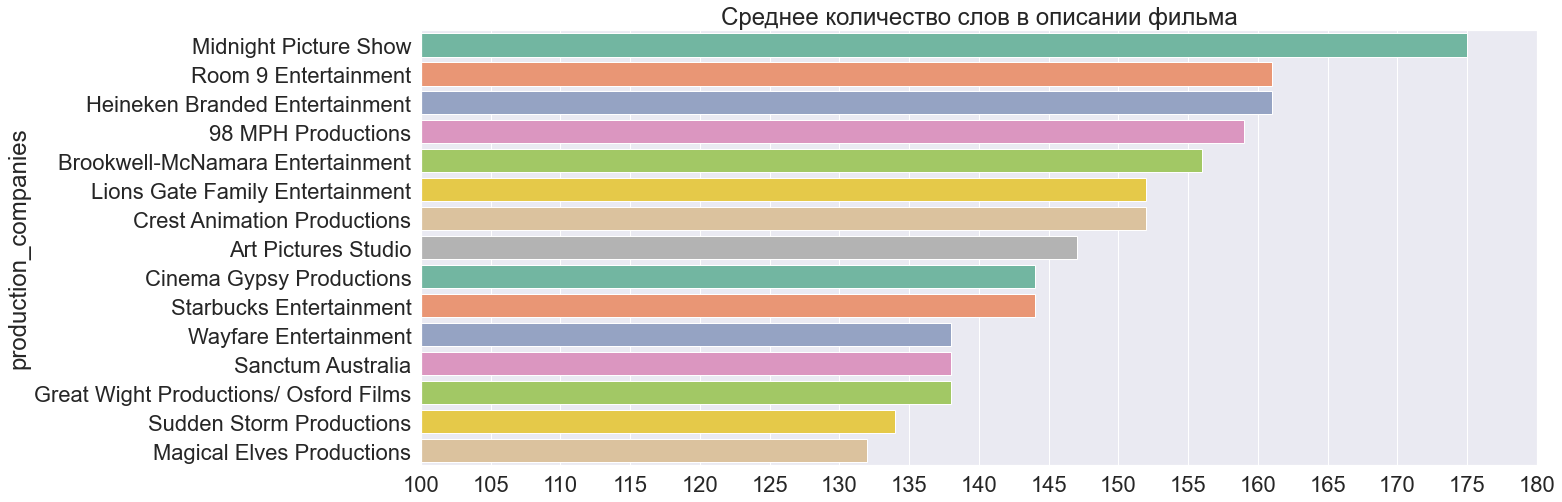

In [54]:
print("В среднем больше всего слов в описании фильма у студии {} ({} символов)".format(
    data_companies.groupby(['production_companies'])['words_in_overview'].mean().idxmax(),
    data_companies.groupby(['production_companies'])['words_in_overview'].mean().max()))

sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.title('Среднее количество слов в описании фильма')
plt.xticks(ticks=range(0, 185, 5))
plt.xlim(100)
sns.barplot(x=data_companies.groupby([
    'production_companies'])['words_in_overview'].mean().sort_values(ascending=False)[:15].values,
            y=data_companies.groupby([
    'production_companies'])['words_in_overview'].mean().sort_values(ascending=False)[:15].index,
            palette='Set2', 
            orient='h')

In [55]:
answers['25'] = data_companies.groupby(['production_companies'])['words_in_overview'].mean().idxmax()

## 26. Какие фильмы входят в 1 процент лучших по рейтингу? 


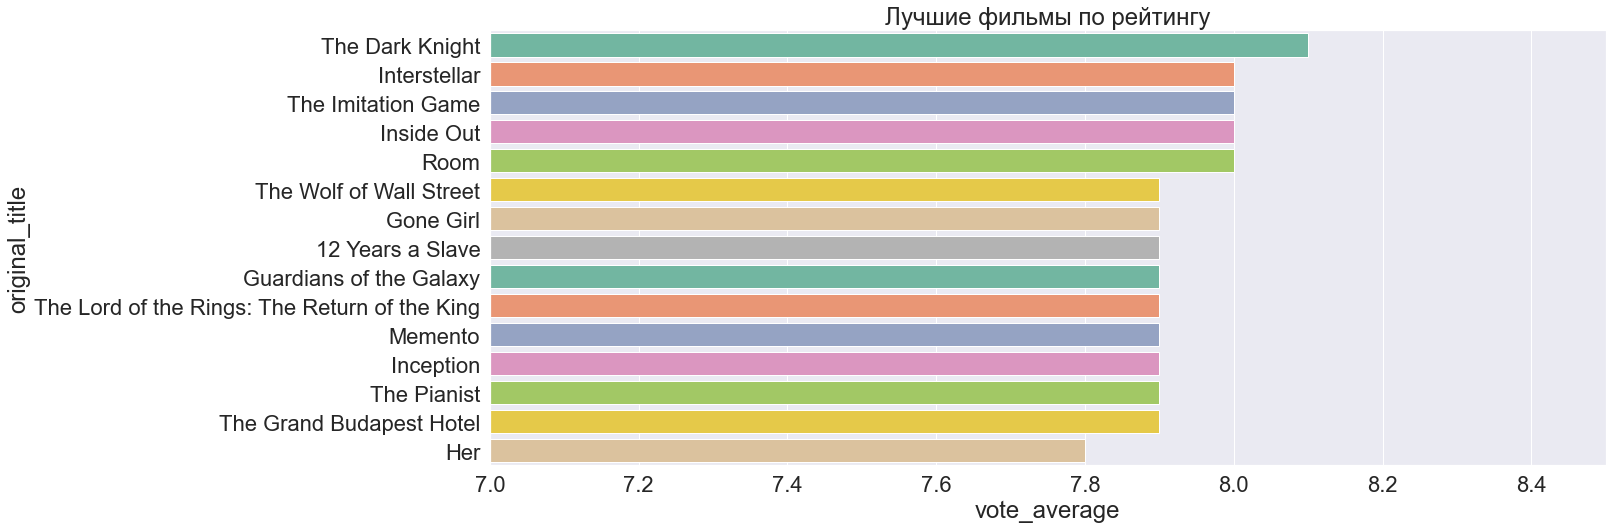

In [56]:
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.title('Лучшие фильмы по рейтингу')
plt.xlim(7, 8.5)
sns.color_palette("Set2")
sns.barplot(x=data.sort_values(by='vote_average', ascending=False)[:15]['vote_average'],
            y=data.sort_values(by='vote_average', ascending=False)[:15]['original_title'],
            palette='Set2', 
            orient='h')

In [77]:
answers['26'] = data[data['vote_average'] > data['vote_average'].quantile(0.99)]['original_title'].tolist()

## 27. Какие актеры чаще всего снимаются в одном фильме вместе?


In [58]:
data['pairs'] = data['cast'].apply(lambda x: list(combinations(x,2)))
data_pairs = data.explode('pairs')
Counter(data_pairs['pairs']).most_common(1)

[(('Daniel Radcliffe', 'Rupert Grint'), 8)]

In [59]:
answers['27'] = Counter(data_pairs['pairs']).most_common(1)[0][0]

# Submission

In [115]:
answers  # в конце смотрим ответы к каждому вопросу

{'1': 'Pirates of the Caribbean: On Stranger Tides',
 '2': 'Gods and Generals',
 '3': 'Winnie the Pooh',
 '4': 109.6585494970884,
 '5': 107.0,
 '6': 'Avatar',
 '7': 'The Lone Ranger',
 '8': 1478,
 '9': 'The Dark Knight',
 '10': 'The Lone Ranger',
 '11': 'Drama',
 '12': 'Drama',
 '13': 'Peter Jackson',
 '14': 'Robert Rodriguez',
 '15': 'Chris Hemsworth',
 '16': 'Matt Damon',
 '17': 'Action',
 '18': 'K-19: The Widowmaker',
 '19': 2015,
 '20': 2014,
 '21': 'September',
 '22': 450,
 '23': 'Peter Jackson',
 '24': 'Four By Two Productions',
 '25': 'Midnight Picture Show',
 '26': ['Inside Out',
  'Room',
  'Interstellar',
  'Guardians of the Galaxy',
  'The Imitation Game',
  'Gone Girl',
  'The Grand Budapest Hotel',
  'Inception',
  'The Dark Knight',
  'The Pianist',
  'The Lord of the Rings: The Return of the King',
  'The Wolf of Wall Street',
  '12 Years a Slave',
  'Memento'],
 '27': ('Daniel Radcliffe', 'Rupert Grint')}

In [61]:
len(answers)  # и убеждаемся, что ни чего не пропустили

27